<a href="https://colab.research.google.com/github/federicotarozzi/Corso_AnalistaProgrammatoreDatiGeoSpaziali/blob/main/1_DL_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite Image Classification
Author: Noemi Fazzini, MEEO S.r.l.

Develop a simple neural network model that can  classify satellite images using Pytorch, an open source machine learning library primarily used for Deep Learning applications.

The used dataset has 4 different classes mixed from Sensors and google map snapshot, namely: cloudy; desert; green area; and water.
Link to original dataset: https://www.kaggle.com/mahmoudreda55/satellite-image-classification

#### Overview

1. Import Libraries
2. Load, split and transform the data into train and test
3. Plot some images
4. Load a pre-trained dense net model and Define neural networks
5. Define the training steps
6. Plot the training step graph
7. Save trained model
8. Use the trained model for predicting the satellite image classes

<hr>

### Import Libraries

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
from torch import optim
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

#### Load data from shared drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load, split and transform the data into train and test

In [ ]:
data_dir = '/content/drive/MyDrive/CorsoAnalistaDatiGeospaziali/img_classification_dataset/'
print("Classes: ", os.listdir(data_dir))

Classes:  ['water', 'desert', 'green_area', 'cloudy']


In [ ]:
# Data transforms (normalization & data augmentation)

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_transforms = transforms.Compose([transforms.RandomCrop(64, padding=4, padding_mode='reflect'),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(*stats,inplace=True),
                                        transforms.Resize(64)
                                       ])

test_transforms = transforms.Compose([transforms.Resize(64),
                                      transforms.ToTensor(),
                                     ])

In [ ]:
batch_size = 64
num_classes = len(os.listdir(data_dir))

In [ ]:
# Split the dataset into training and testing sets (50+10+10=len(dataset))
dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=True)

### Plot some images

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

def show_batch(dl):
    for images, labels in dl:
        # Denormalize the images
        denorm_images = denormalize(images, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # Set up the figure with subplots
        fig, axes = plt.subplots(figsize=(12, 12), nrows=8, ncols=8)
        fig.subplots_adjust(hspace=0.5)

        # Flatten axes for easy iteration
        axes = axes.flatten()

        # Loop through images and labels, and plot them
        for i, (img, label) in enumerate(zip(denorm_images, labels)):
            ax = axes[i]
            img = img.permute(1, 2, 0).numpy().clip(0, 1)  # Change channel order and clip values
            ax.imshow(img)
            ax.set_title(dataset.classes[label], fontsize=8)
            ax.axis('off')

        plt.show()
        break

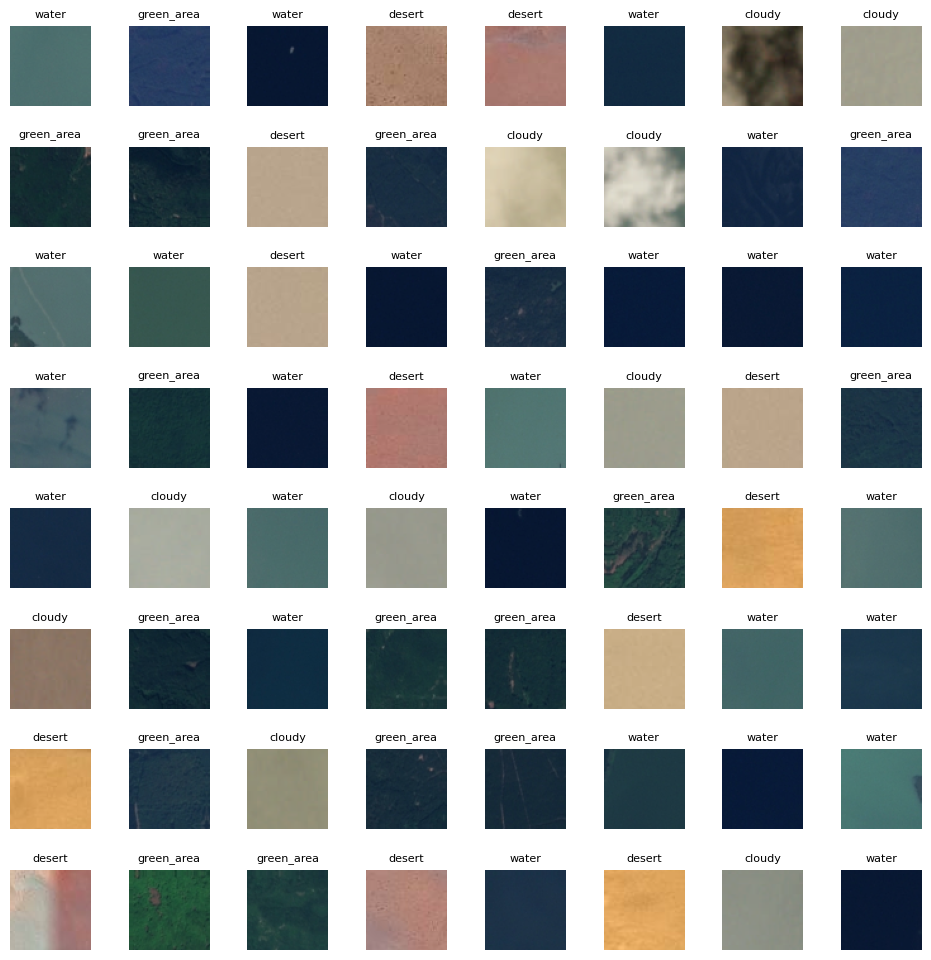

In [ ]:
show_batch(train_loader)

### Load a pre-trained dense net model and define neural network

In [ ]:
model = models.densenet161(weights=True)

/home/fazzini/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Train only the classifier parameters, feature parameters are frozen
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create classifier model
model.classifier = nn.Sequential(nn.Linear(1024,512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512,256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256,num_classes),
                                 nn.LogSoftmax(dim=1)
                                 )

# Choose loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Define the training steps

In [ ]:
traininglosses = []
validlosses = []
validaccuracy = []
totalsteps = []

# parameters
epochs = 3
steps = 0
running_loss = 0
print_every = 5

# loop over the training dataset
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        # Clear the gradients of all optimized tensors
        optimizer.zero_grad()

        # Backward propagation and optimizer step to update the weights
        logps = model.forward(inputs)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss = criterion(logps, labels)
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()

        running_loss += loss.item()

        # Validation step
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0

            # Set the model to evaluation mode
            model.eval()
            # Turn off gradients
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    valid_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            traininglosses.append(running_loss/print_every)
            validlosses.append(valid_loss/len(valid_loader))
            validaccuracy.append(accuracy/len(valid_loader))
            totalsteps.append(steps)
            print(f"Device {device}.."
                  f"Epoch {epoch+1}/{epochs}.. "
                  f"Step {steps}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            model.train()

Device cpu..Epoch 1/3.. Step 5.. Train loss: 5.219.. Validation loss: 5.162.. Validation accuracy: 0.346
Device cpu..Epoch 1/3.. Step 10.. Train loss: 0.336.. Validation loss: 3.055.. Validation accuracy: 0.382
Device cpu..Epoch 1/3.. Step 15.. Train loss: 0.422.. Validation loss: 1.965.. Validation accuracy: 0.482
Device cpu..Epoch 1/3.. Step 20.. Train loss: 0.403.. Validation loss: 1.422.. Validation accuracy: 0.559
Device cpu..Epoch 1/3.. Step 25.. Train loss: 0.357.. Validation loss: 0.842.. Validation accuracy: 0.708
Device cpu..Epoch 1/3.. Step 30.. Train loss: 0.452.. Validation loss: 0.620.. Validation accuracy: 0.793
Device cpu..Epoch 1/3.. Step 35.. Train loss: 0.341.. Validation loss: 0.506.. Validation accuracy: 0.832
Device cpu..Epoch 1/3.. Step 40.. Train loss: 0.417.. Validation loss: 0.427.. Validation accuracy: 0.859
Device cpu..Epoch 1/3.. Step 45.. Train loss: 0.368.. Validation loss: 0.383.. Validation accuracy: 0.873
Device cpu..Epoch 1/3.. Step 50.. Train loss: 0

### Plot the training step graph

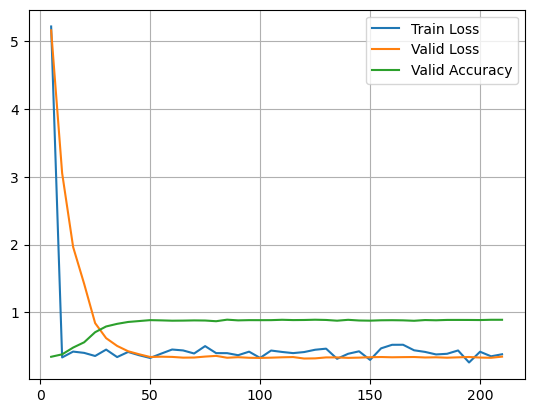

In [ ]:
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, validlosses, label='Valid Loss')
plt.plot(totalsteps, validaccuracy, label='Valid Accuracy')
plt.legend()
plt.grid()
plt.show()

### Save trained model

In [ ]:
torch.save(model, 'newsatmodel.pth')

### Use the trained model for predicting the satellite image classes from the test dataset

In [ ]:
model2 = torch.load('./newsatmodel.pth')
model=model2

In [ ]:
#test_dataset.dataset.transform = test_transforms
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=True)

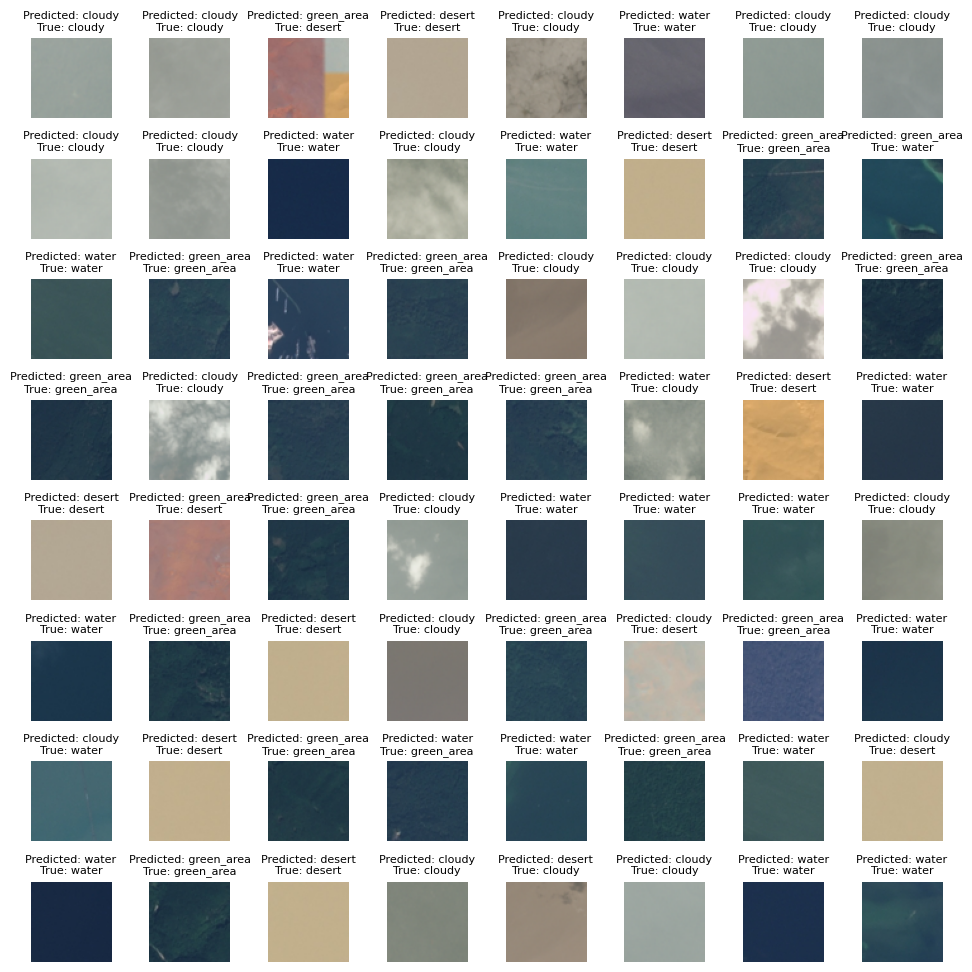

In [ ]:
def predict_image(image, model, device, transform):
    # Apply transformation (if any) to convert the image to tensor
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)  # Add batch dimension
    input = image_tensor.to(device)

    # Forward pass through the model
    with torch.no_grad():
        output = model(input)

    index = output.data.cpu().numpy().argmax()
    return index

model.eval()

y_true = []
y_pred = []

fig, axes = plt.subplots(figsize=(12, 12), nrows=8, ncols=8)
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    for j in range(len(images)):
        image = transforms.ToPILImage()(images[j].cpu())  # Convert tensor to PIL image
        index = predict_image(image, model, device, test_transforms)
        predicted_label = dataset.classes[index]
        true_label = dataset.classes[labels[j]]

        y_true.append(true_label)
        y_pred.append(predicted_label)

        ax = axes[j]
        ax.imshow(image)
        ax.set_title(f'Predicted: {predicted_label}\nTrue: {true_label}', fontsize=8)
        ax.axis('off')

    plt.show()
    break  # Show only one batch

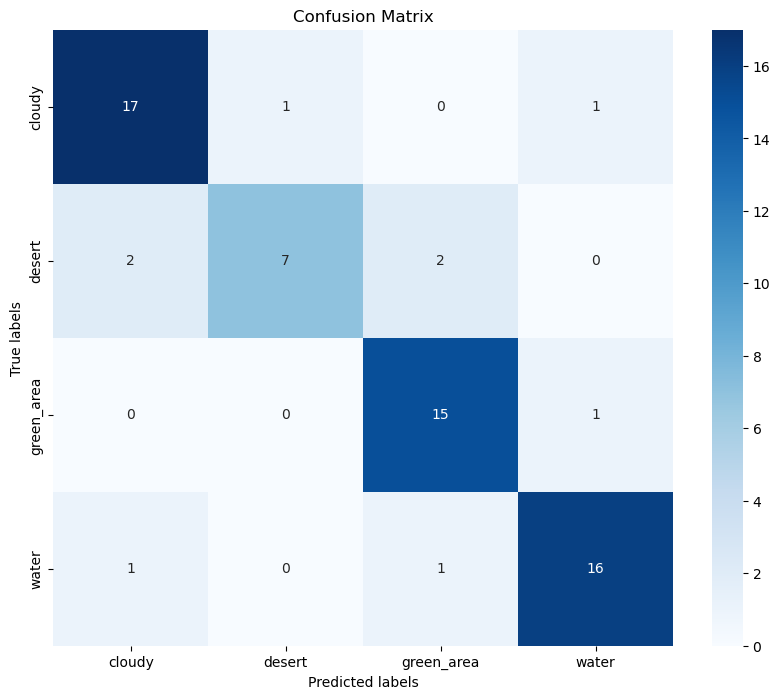

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=dataset.classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()